In [53]:
#TODO
#1. Add new critical addition and non-critical addition of charge tasks
#2  
#3. Add removal of charge tasks that lead to negative increase in charge after LP
#3. Convert all constants to UPPERCASE

In [54]:
#DEBUG FUNCTION
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace
def debugIt(statement):
    pass
#     print(statement)


env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


### Imports

In [55]:
import numpy as np
import pandas as pd
from pandas import read_excel
from sklearn.preprocessing import normalize # for normalizing distance matrix
import matplotlib.pyplot as plt
from csv import reader
import functools # for reduce
from gurobipy import *
import random 
import copy # to deep copy from taskSequence to taskSchedule
from time import *

### Station

In [56]:
'''
Station Object
- Pickup / Delivery Nodes
- Charging Nodes
'''
class Station():
    
    def __init__(self,nodeId,name, stType, mhTime):
        self.nodeId = int(nodeId) # an integer representing the unique id of a node
        self.name = name #name of the node
        self.stType = stType #station Type (P/D/C/PD)
        self.mhTime = mhTime # material handling time associated with the station 
    
    def __repr__(self):
        return f"Station#{self.nodeId} - {self.name} - {self.stType}"
    
    def getType(self):
        '''
        Returns type of node
        '''
        return self.stType
    
    def getNode(self):
        '''
        returns integer id of the node
        '''
        return self.nodeId
    
    def getMHT(self):
        '''
        returns material handling time at the station
        '''
        return self.mhTime

### Task
This class represents the following types of tasks:
Charge Task,
Non-Critical Charge task,
MH Task,
Unloaded Travel Task

In [57]:
'''
Class representing a task
Charge Task
Non-Critical Charge task
MH Task
Unloaded Travel Task
'''
class Task():
    
    def __init__(self, taskId, taskType, source, dest):
        self.taskId=taskId #this is the original id of the request from the file
        self.taskIndex=888 #this is changed based on order of tasks, use this to locate charge tasks
        self.taskType = taskType
        self.source = source
        self.dest = dest
        
    def __repr__(self):
        return f"{self.taskId}-{self.taskType}-{self.source}-{self.dest}"
    
    def getTaskId(self):
        '''
        returns the unique id of the task
        '''
        return self.taskId

### Transport Order Task (Inherited from Task)

In [58]:
'''
This class represents an inherited object(Transport Order) of a TASK'''
class TransportOrder(Task):
    def __init__(self,taskId, taskType, source, dest, ept, ldt, cap):
        super().__init__(taskId, taskType, source, dest) #call 'Task' class constructor
        self.ept = ept
        self.ldt = ldt
        self.cap = cap
        
    def __repr__(self):
        return f"{self.taskId}-{self.taskType}-{self.source}-{self.dest}-{self.ept}-{self.ldt}-{self.cap}"
    
    def getEPT(self):
        return self.ept
    
    def getLDT(self):
        return self.ldt

### Layout

In [59]:
class Layout():
    
    def __init__(self, fileName):
        self.distMat=[]
        self.normalizedDistanceMatrix=[]
        self.readDistanceMatrix(fileName)
        self.setNormalizedDistanceMatrix()
    
    def readDistanceMatrix(self,fileName):
        dm = reader(open(fileName))
        self.distMat = list(dm)
        self.distMat[0][0]=0
        
        for f,fr in enumerate(self.distMat):
            for t,to in enumerate(fr):
                self.distMat[f][t] = float(self.distMat[f][t])
                
    
    def getDistanceFromNode(self, source, dest):
        '''
        returns the distance (in m) between 2 nodes
        '''
        return float(self.distMat[source][dest])
    
    def getMaxDistance(self):
        '''
        returns the maximum distance value
        '''
        maximum_distance=0
        for i in self.distMat:
            for j in i:
                if j>maximum_distance:
                    maximum_distance=j
        return maximum_distance
    
    def setNormalizedDistanceMatrix(self):
        '''
        keeps a normalized version of distance matrix
        '''
        self.normalizedDistanceMatrix = copy.deepcopy(self.distMat)
        self.normalizedDistanceMatrix = normalize(self.normalizedDistanceMatrix)
    
    def getNormalizedDistanceFromNode(self, source, dest):
        '''
        returns normalized distance from distance matrix
        '''
        return float(self.normalizedDistanceMatrix[source][dest])
    
    def getDistanceMatrix(self):
        '''
        returns a copy of the distance matrix
        '''
        return copy.deepcopy(self.distMat)
                

### AGV

In [60]:
class AGV():
    def __init__(self, agvId, startNode, caps, speed, charge, dischargeRate, chargeRate, taskList, travelCost, low=30, up=60):
        
        self.agvId = agvId #agv id
        self.startNode = startNode #initial node
        self.caps = caps #capability
        self.speed = speed # speed in m/s
        self.charge = charge # charge %
        self.dischargeRate = dischargeRate # % per second
        self.chargeRate = chargeRate # % per second
        self.travelCost = travelCost # weighted travel cost
        self.LOWER_THRESHOLD = low # lower threshold of charging
        self.UPPER_THRESHOLD =up # upper threshold of charging
        self.state = 'N'
    
    def __repr__(self):
        return f"{self.agvId}-{self.speed}m/s-{self.charge}%-{self.travelCost}"
    
    def getSpeed(self):
        '''
        Returns speed of agv in m/s
        '''
        return self.speed
    
    def getChargeRate(self):
        '''
        Returns charging rate of agv in %/sec
        '''
        return self.chargeRate
    
    def getDischargeRate(self):
        '''
        Returns discharging rate of agv in %/sec
        '''
        return self.dischargeRate
    

### Scheduler Class
This class is responsible for scheduling tasks on AGVs based on system state

In [61]:
class Scheduler():
    
    
    def __init__(self, layoutFile, agvFile, requestFile, stationFile):
        self.agvs =[] # field responsible to keep track of agvs
        self.agvsInfo=dict() # field to keep track of agv charge, location etc...
        self.stations=[] # field responsible to keep track of stations
        self.layout = None 
        self.transportOrders = list()
        self.chargingStations = list()
        self.nearestChargeFromStation=dict()
        self.taskList = dict() # this contains a processed list of TOs and Chargetasks, produced during greedy sequencing
        self.taskSequence = dict() # it is made AFTER all tos and charge tasks are assigned i.e. after greedy sequencing, taskSequence is sent for scheduling
        self.taskSchedule = dict() # order of execution -> create taskList->create taskSequence->schedule via LP->taskSchedule
        self.normalizedT=dict() #to store normalized EPT values
        self.createLayout(layoutFile=layoutFile)
        self.createAGVs(agvFile=agvFile)
        self.createStations(stationFile=stationFile)
        self.createRequests(requestFile=requestFile)
        self.setAGVInfo() # create a JSON like agv information object
        self.stationALNSMethods = ALNSStationDestroyAndRepairMethods(self) # instantiating ALNS repair method class
        self.setNearestChargeLocation() # keep a dictionary of from to relationship b/w source station to charging stations
        self.customerALNSMethods = ALNSCustomerDestroyAndRepairMethods(self)

        
    def setAGVInfo(self):
        '''
        Keeps a record of agv location charge etc.
        '''
        for a,agv in enumerate(self.agvs):
            self.agvsInfo[a]={}
            self.agvsInfo[a]['charge']=agv.charge
            self.agvsInfo[a]['startNode']=agv.startNode
            self.agvsInfo[a]['release']=(0, agv.startNode) #(time, location)
            self.agvsInfo[a]['state']=agv.state
            
    def getCurrentReleaseNode(self, agv):
        '''
        returns agv's current release node
        '''
        return self.agvsInfo.get(agv.agvId)['release'][1]
    
    def setCurrentReleaseNode(self,agv, releaseNode):
        '''
        sets the release node of an agv
        '''
        self.agvsInfo.get(agv.agvId)['release']=(self.agvsInfo.get(agv.agvId)['release'][0],releaseNode)
        
    def getCurrentReleaseTime(self,agv):
        
        '''
        returns the time at which AGV leaves/can leave the release node
        '''
        return self.agvsInfo.get(agv.agvId)['release'][0]
    
    def setCurrentReleaseTime(self,agv,releaseTime):
        '''
        sets agv release time
        '''    
        self.agvsInfo.get(agv.agvId)['release']=(releaseTime,self.agvsInfo.get(agv.agvId)['release'][1])

    
    def setState(self,agv,state):
        '''
        Sets the state of agv to Normal ='N' or Charging = 'C'
        '''
        self.agvsInfo.get(agv.agvId)['state'] = state
        
    def getState(self,agv):
        '''
        Returns state of agv, 'N'=Normal, 'C'=Charging
        '''
        return self.agvsInfo.get(agv.agvId)['state']
        
    def setCharge(self, agv,charge):
        '''
        Sets the agv charge
        '''
        self.agvsInfo.get(agv.agvId)['charge'] = min(100,charge)
        
    def getCharge(self,agv):
        '''
        Returns AGV Charge in %age
        '''
        return self.agvsInfo.get(agv.agvId)['charge']
    
    def getStartNode(self,agv):
        '''
        Returns agv's initial/start node'''
        return self.agvsInfo.get(agv.agvId)['startNode']
        
        
    def createLayout(self, layoutFile):
        '''
        Creates digital layout inside scheduler
        '''
        self.layout = Layout(fileName=layoutFile)
        
    def createAGVs(self, agvFile):
        '''
        Creates agvs
        '''
        df =read_excel(agvFile)
        #TODO - modify lower threshold of agv based on 2*max distance in the layout and discharge rate of agvs
        for index,row in df.iterrows():
            agv = AGV(agvId=row['agvidf'], startNode=row['startNode'],caps= row['capability'], speed=row['speed'], \
                      charge=row['charge'],dischargeRate= row['dischargeRate'], chargeRate = row['chargingRate'],\
                      travelCost = row['travelCost'], low = row['lowerThreshold'], up = row['upperThreshold'], taskList=None)
            self.agvs.append(agv)
        for agv in self.agvs:
            safety_charge = (self.layout.getMaxDistance()/agv.speed)*agv.dischargeRate
            agv.LOWER_THRESHOLD+=safety_charge # to ensure feasibility of LP

            
    def createStations(self, stationFile):
        '''
        Creates stations
        '''
        df = read_excel(stationFile)
        for index, row in df.iterrows():
            station = Station(nodeId=row['id'], name=row['pointidf'], stType=row['type'], mhTime=row['mhtime'])
            self.stations.append(station)
            if station.getType() == 'C':
                self.chargingStations.append(station)
        
    
    def createRequests(self, requestFile):
        '''
        Creates TOs that need to be scheduled
        '''
        df =read_excel(requestFile)
        epts=[]
        ldts=[]
        for index,row in df.iterrows():
            transportOrder = TransportOrder(taskId=row['Id'], taskType='TO', source=row['source'],\
                                            dest= row['target'],ept= row['ept'], ldt=row['ldt'], cap=row['capability'])
            self.transportOrders.append(transportOrder)
            epts.append(row['ept'])
            ldts.append(row['ldt'])
            self.normalizedT[row['Id']]=(row['ept'],row['ldt'])
            
        minEptLi, maxEptLi = min(epts),max(epts)
        minLdtLi, maxLdtLi = min(ldts),max(ldts)
        #create normalized ept and ldt values to be used in shaw relatedness function
        for r,val in self.normalizedT.items():
            self.normalizedT[r]=((val[0]-minEptLi)/(maxEptLi-minEptLi), (val[1]-minLdtLi)/(maxLdtLi-minLdtLi)) 
               
            
    def getNormalizedEPT(self,task):
        '''
        returns normalized ept
        '''
        return self.normalizedT.get(task.taskId)[0]
    
    def getNormalizedLDT(self,task):
        '''
        returns normalized ept
        '''
        return self.normalizedT.get(task.taskId)[1]
    
    def getAgvById(self,agvId):
        '''
        returns agv object by id
        '''
        return next((agv for agv in self.agvs if agv.agvId==agvId),None) #returns agv or None if not found
    
    def getMhtById(self,nodeId):
        '''
        returns mh time for node
        '''
        return next(st.getMHT() for st in self.stations if st.nodeId==nodeId)
        
    
            
#'''
#HEREUNDER LIES THE GREEDY SEQUENCING HEURISTIC
#'''

    def checkCap(self,to, agv):
        '''
        This function checks if the agv has required capabilities to do the task
        '''
        toCap = to.cap.split(',')
        
        b=[str(c) in agv.caps for c in toCap]
        return functools.reduce(lambda x,y: x and y,b) # reduce does pairwise comparison of 2 objects in a list
        

    def createGreedySequence(self):
        '''
        This function creates a greedy sequence of tasks to be performed, calls createTaskSequence to make a sequence list 
        with unloaded travel etc.
        '''
        #initialize the taskList dict object of scheduler
        self.taskList = dict()
        for a,agv in enumerate(self.agvs):
            self.taskList[agv.agvId]=[]
        
        self.transportOrders.sort(key = lambda x: x.ldt) # sort based on delivery time
        #assign tasks to AGVs and keep checking for expected charge after finishing the task
        for to in self.transportOrders:
            agv_count = [agv for agv in self.agvs if self.checkCap(to,agv)]
            # assert that there is at least one agv with desired capability
            assert (len(agv_count)>0), ("There should always be at least one agv with desired capability")
            if len(agv_count)==1:
                #add the task to AGV
                self.addGreedyTask(agv_count[0],to)
            elif len(agv_count)>1:
                scores=[]
                for agv in agv_count:
                    score = self.getScore(agv,to)
                    scores.append(score)
                optAGV = scores.index(min(scores))
                self.addGreedyTask(agv_count[optAGV],to)
        
                
#         #AFTER HAVING CREATED A TASK LIST, add normalized ept and ldt values for shaw removal
#         eptLi=[]
#         ldtLi=[]
#         self.normalizedT=dict.fromkeys(self.taskList,[]) # create a dictonay with keys as from tasklist and value as empty
#         #list
#         for key,val in self.taskList.items(): # for agv and tasklist 
            
#             eptLi=[e.getEPT() for e in val if e.taskType=='TO'] #create a list of all epts
#             ldtLi=[e.getLDT() for e in val if e.taskType=='TO'] #create a list of all ldts
            
#             minEptLi, maxEptLi = min(eptLi),max(eptLi)
#             minLdtLi, maxLdtLi = min(ldtLi),max(ldtLi)
            
#             eptLi=[(e-minEptLi)/(maxEptLi-minEptLi) for e in eptLi] #normalize
#             ldtLi=[(e-minLdtLi)/(maxLdtLi-minLdtLi) for e in ldtLi] #normalize
            
#             normalT=self.normalizedT.get(key)
#             c=0
#             for v in val:
#                 if v.taskType=='TO':
#                     normalT.append((v.getTaskId(),eptLi[c],ldtLi[c]))
#                     c+=1
                
#         print(self.normalizedT)
        
            
                
    
    
    def getScore(self,agv,task):
        srcStation = list(filter(lambda x:x.nodeId==task.source,self.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,self.stations))[0] # destination station
        if self.getCharge(agv)<agv.LOWER_THRESHOLD:
            #unloaded travel Cost
            dists = [self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),station.getNode())\
                     for station in self.chargingStations]
            optIndex = dists.index(min(dists))
            nearestChargeNode = self.chargingStations[optIndex].getNode()
            distScore = (self.layout.getDistanceFromNode(nearestChargeNode,task.source)+ \
                         self.layout.getDistanceFromNode(task.source,task.dest))*agv.travelCost
            
            #tardiness score
            tardScore=0
            travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),nearestChargeNode)
            drivingTime = travelDist/agv.speed # time spent in driving
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge(agv))/agv.chargeRate
            absRelTime = self.getCurrentReleaseTime(agv)+minChargeTime+drivingTime
            dist = self.layout.getDistanceFromNode(nearestChargeNode,task.source)+\
                self.layout.getDistanceFromNode(task.source,task.dest)
            
            if absRelTime>task.ept:
                time = absRelTime+dist/agv.speed +srcStation.mhTime + dstStation.mhTime
            else:
                time = task.ept+dist/agv.speed +srcStation.mhTime + dstStation.mhTime
            
            tardiness = max(0,time-task.ldt)
            
            tardScore = tardiness**2
            
            return tardScore + distScore
        
        else:
            #dist score
            distScore = (self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source)+self.layout.getDistanceFromNode(task.source,task.dest))*agv.travelCost
            #tardiness score
            tardScore=0
            dist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source)+\
                self.layout.getDistanceFromNode(task.source,task.dest)
            
            absRelTime = max(self.getCurrentReleaseTime(agv),task.ept)
            
            time = absRelTime+dist/agv.speed+srcStation.mhTime+dstStation.mhTime
            
            tardiness = max(0,time-task.ldt)
            
            tardScore = tardiness**2
            
            return tardScore + distScore
        
    
    def addChargeTask(self,agv):
        '''
        Adds a charge task to the agv's tasklist
        '''
        dists = [self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),station.getNode()) for station in self.chargingStations]
        optIndex = dists.index(min(dists))
        nearestChargeNode = self.chargingStations[optIndex].getNode()
        chargeTask = Task(999,'C','X','X')
        
#         agv.taskList.append(chargeTask) #REMOVE LATER
        self.taskList.get(agv.agvId).append(chargeTask)
        self.setState(agv,'C') #charging
        
        travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),nearestChargeNode)
        drivingTime = travelDist/agv.speed # time spent in driving
        self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
        
        self.setCurrentReleaseNode(agv,nearestChargeNode)
        self.setCurrentReleaseTime(agv,self.getCurrentReleaseTime(agv)+drivingTime)

        
    def addTaskToTaskList(self,agv,task):
        #add a TO to agv's task list 
        travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source) + \
                        self.layout.getDistanceFromNode(task.source, task.dest)
            
        srcStation = list(filter(lambda x:x.nodeId==task.source,self.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,self.stations))[0] # destination station
        drivingTime = travelDist/agv.speed # time spent in driving
        
        if self.getState(agv)=='N':
            travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#             agv.taskList.append(task) #REMOVE LATER
            self.taskList.get(agv.agvId).append(task)
            self.setCurrentReleaseNode(agv,task.dest)
            self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
            self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
            self.setState(agv,'N')
        
        elif self.getState(agv)=='C':
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge(agv))/agv.chargeRate # time to reach LOWER_THRESHOLD charge level
            minChargeAbsTime = self.getCurrentReleaseTime(agv) + max(0,minChargeTime)  # the absolutime time (in sec) at which AGV becomes 30% charged
            
            if task.ept >= minChargeAbsTime :
                # add the task but update charge based on delta
                chargeTime = (task.ept - self.getCurrentReleaseTime(agv))
                self.setCharge(agv,self.getCharge(agv) + (chargeTime * agv.chargeRate)) # charge after charging till task's ept
                self.setCurrentReleaseTime(agv,self.getCurrentReleaseTime(agv)+chargeTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                self.taskList.get(agv.agvId).append(task)
                self.setCurrentReleaseNode(agv,task.dest)
                self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
                self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
                self.setState(agv,'N')
                
            elif task.ept < minChargeAbsTime:
                #
                self.setCurrentReleaseTime(agv,minChargeAbsTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                self.taskList.get(agv.agvId).append(task)
                self.setCurrentReleaseNode(agv,task.dest)
                self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
                self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
                self.setState(agv,'N')
                
         
        
    def addGreedyTask(self,agv,task):

        if self.getCharge(agv)>=agv.LOWER_THRESHOLD and self.getState(agv) =='N':
            #add the task
            self.addTaskToTaskList(agv,task)
            
        elif self.getCharge(agv)<agv.LOWER_THRESHOLD and self.getState(agv)=='N':
            # add a charge task
            self.addChargeTask(agv)
            
        if self.getCharge(agv)<agv.LOWER_THRESHOLD and self.getState(agv)=='C':
            #update the charge at time of new request, if sufficient charge is present, change state, add the task
            self.addTaskToTaskList(agv,task)
            
    
    def writeToTaskSequence(self, agvId, task):
        '''
        write a task of an agv to scheduler's task sequence 
        '''
        taskDict={}
        taskDict['taskIndex']=task.taskIndex
        taskDict['taskId']=task.taskId
        taskDict['taskType']=task.taskType
        taskDict['source']=task.source
        taskDict['dest']=task.dest       
        try:
            taskDict['mhTime'] = list(filter(lambda x:x.nodeId==task.source,self.stations))[0].getMHT()
        except IndexError:
            print(f'id of task{task}:{id(task)}')
            
        if task.taskType=='TO':
            taskDict['ept']=task.ept
            taskDict['ldt']=task.ldt
        self.taskSequence.get(agvId).append(taskDict)
#         print(self.taskList)
    
    def setNearestChargeLocation(self):
        '''
        creates a dictionary of nearest charge locations from nodes in a layout
        '''
        stations = [s.getNode() for s in self.stations]
        for s in stations:
            dists = [self.layout.getDistanceFromNode(s, station.getNode()) for station in self.chargingStations]
            optIndex = dists.index(min(dists))
            nearestChargeNode = self.chargingStations[optIndex].getNode()
            self.nearestChargeFromStation[s] = nearestChargeNode
            
            
    def getNearestChargeLocation(self, stationNode):
        '''
        returns nodeId of nearest charge location
        '''
        return self.nearestChargeFromStation.get(stationNode)
    
    def fixChargeOrganiseTaskList(self):
        '''
        Checks for multiple charge tasks and assigns source and destination of charge tasks
        '''
         #check tasklist and remove duplicate charge tasks and add charge task source and destination
        for agv,tl in self.taskList.items():
            taskListLen=len(tl)-1
            toRemove=[]
            tasklist= self.taskList.get(agv)
            for t in range(taskListLen):
                if tasklist[t].taskType=='C' and t!=0:
                    if tasklist[t+1].taskType=='C':
                        toRemove.append(tasklist[t+1])
#                     print(f'id of task inside createTask{tasklist[t]}:{id(tasklist[t])}')
                    tasklist[t].source = tasklist[t-1].dest
#                     print(tasklist[t].source)
                    tasklist[t].dest = self.getNearestChargeLocation(tasklist[t].source)
                elif tasklist[t].taskType=='C' and t==0:
                    if tasklist[t+1].taskType=='C':
                        toRemove.append(tasklist[t+1])
                    tasklist[t].source = self.getStartNode(self.agvs[agv])
                    tasklist[t].dest = self.getStartNode(self.agvs[agv])
                elif t==taskListLen-1 and tasklist[t+1].taskType=='C':
                    tasklist[t+1].source = tasklist[t].dest
                    tasklist[t+1].dest = self.getNearestChargeLocation(tasklist[t+1].source)
                    
            tasklist[:] =[t for t in tasklist if t not in toRemove]
            
        
    def createTaskSequence(self):
        '''
        function that converts scheduler's taskList into a scheduler's taskSequence (postprocessing - add ut tasks)
        and checks for multiple charge tasks and assigns source and destination of charge tasks
        ''' 
       
        self.fixChargeOrganiseTaskList()
        #Create task Sequence
        self.taskSequence={}
        #create keys in taskList for AGVs
        for agv in self.agvs:
            for task in self.taskList.get(agv.agvId):
                task.taskIndex = self.taskList.get(agv.agvId).index(task) #assigning index
        #create agv keys
        for agv in self.agvs:
            taskListLength = len(self.taskList.get(agv.agvId)) # length of tasks in task list
            self.taskSequence[agv.agvId]=[] # assign an empty list to each agv in task sequence
            if len(self.taskList.get(agv.agvId))>0:
                ut = Task(998,'UT',self.getStartNode(agv), self.taskList.get(agv.agvId)[0].source) 
                #create a UT(Unloaded Travel)
                #task, id and index dont matter'''
                self.writeToTaskSequence(agv.agvId,ut)
            for t,task in enumerate(self.taskList.get(agv.agvId)): # for rest of the tasks
                self.writeToTaskSequence(agv.agvId,task)
                if t< taskListLength-1 and self.taskList.get(agv.agvId)[t+1].taskType=='TO': # if not end of list and 
                    # next task is some kind of TO and not charge
                    ut = Task(998,'UT',task.dest, self.taskList.get(agv.agvId)[t+1].source)  
                    self.writeToTaskSequence(agvId=agv.agvId,task=ut)
                    
        
                
        
                                
#'''
#HEREUNDER LIES THE LP FORMULATION / could be another class
#'''   
    
    
    def solveLP(self,printOutput=False):
        numAGVs=len(self.agvs)
        REQ =[] #List consisting of number of requests
        SRC=[] #List containing SRC of requests
        DEST=[]
        EPT=[]
        LDT=[]
        MHT=[]
        cr=[]
        dcr=[]
        sp=[]
        REQID=[]
        
        #keep track of tasks (UT, TO , C) in agvs
        for a,agv in enumerate(self.agvs):
            REQ.append(len(self.taskSequence.get(a)))
            sp.append(agv.getSpeed())
            cr.append(agv.getChargeRate())
            dcr.append(agv.getDischargeRate())
            SRC.append([])
            DEST.append([])
            EPT.append([])
            LDT.append([])
            MHT.append([])
            REQID.append([])
            
            for r in range(REQ[a]):
                REQID[a].append(self.taskSequence.get(a)[r]['taskId'])
                SRC[a].append(self.taskSequence.get(a)[r]['source'])
                DEST[a].append(self.taskSequence.get(a)[r]['dest'])
                MHT[a].append(self.taskSequence.get(a)[r]['mhTime'])
                EPT[a].append(self.taskSequence.get(a)[r].get('ept') or 0)
                LDT[a].append(self.taskSequence.get(a)[r].get('ldt') or 0)
                
        
        C = [x.getNode() for x in self.chargingStations] # list of charging station nodeIDs
        
        
        #GUROBI
        m = Model('Scheduling')
        m.setParam('OutputFlag',printOutput)
        #minimization model
        m.modelSense = GRB.MINIMIZE
        #decision variables
        #variable for lateness of request r
        Z = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"Z_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])} # 0 becuase we do not consider earliness

        #variable to represent the time instance at which AGV reaches 'source' of a request r
        S = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"S_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])}

        #variable to represent the time instance at which AGV reaches 'destination' of a request r
        D = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"D_{r}_{v}") 
             for v in range(numAGVs)  for r in range(REQ[v])}

        #variable to represent the battery status at the beginning of request r
        B = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, ub=100.0, name = f"B_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])}

        #battery can reach 0% only at charging stations
        for v in range(numAGVs):
            for r in range(REQ[v]):
                if REQID[v][r]<998:
                    B[r,v].lb=30.0 # gurobi syntax to showcase indices
        
        m.update()
        
#         for v in range(numAGVs):
#             print(REQ[v])
#             for r in range(REQ[v]):
#                 print(r,v)
        #objective function
        #Objective 1 - To minimize lateness
        obj_lateness = quicksum(Z[r,v]*Z[r,v] for v in range(numAGVs) for r in range(REQ[v]))

        # #Objective 2 - To maximize charging duration and minimize parking duration at source and destination nodes
#         obj_charging = grb.quicksum(0 if SRC[v][r] in C else 1*(S[r+1,v]-S[r,v]) for r in range(REQ[v]-1) for v in range(numAGVs))

        #Objective 3 - To minimize Unloaded Travel Time
#         obj_unloaded = grb.quicksum(0 if REQID[v][r]<998 else 1*(D[r,v] - S[r,v]) for r in range(REQ[v]) for v in range(numAGVs)) 
        # becoz that's where unloaded travel occurs
        
        #SET OBJECTIVE
        m.setObjective(obj_lateness)
        #adaption for online +obj_charging
        #Constraints

        #Constraint 1 - trip time should be less than Destination time instance
        for v in range(numAGVs):
            for r in range(REQ[v]):
                i=SRC[v][r]
                j=DEST[v][r]
                dist = self.layout.getDistanceFromNode(i,j)
                m.addConstr(S[r,v]+(MHT[v][r]+(1/sp[v])*dist)<=D[r,v],name=f"Headway_{r}_{v}")
                
        #Constraint 2 - Destination of request should equal source of next request
        for v in range(numAGVs):
            for r in range(REQ[v]-1):
                i=SRC[v][r]
                j=DEST[v][r]
                m.addConstr(D[r,v]==S[r+1,v], name=f"Dest_{r}_{v}=Src{r+1}_{v}")
                
        #Constraint 3 - A job cannot be picked up before EPT
        for v in range(numAGVs):
            for r in range(REQ[v]):
                m.addConstr(EPT[v][r]<=S[r,v],name=f"S_{r}_{v}>=EPT_{r}_{v}")
                
        #Constraint 4 - To represent lateness Z = D - LDT 
        for v in range(numAGVs):
            for r in range(REQ[v]):
                if LDT[v][r]>0:
                    m.addConstr(Z[r,v]>=D[r,v]+MHT[v][r]- LDT[v][r], name = f"Z_{r}_{v}>=D_{r}_{v}-LDT_{r}_{v}") # where Z[r] represents slack, when Z{r} is -ve, it will be 0 due to lower bound
        
        #Constraint 5 - Battery initialization at starting nodes to 100%
        for v in range(numAGVs):
            m.addConstr(B[0,v]==100, name=f"B_0_init_{v}") #remove hardcoded 100 here

        #Constraint 6 - Battery discharging and charging
        for v in range(numAGVs):
            for r in range(REQ[v]-1):
                i=SRC[v][r]
                j=SRC[v][r+1]
                dist = self.layout.getDistanceFromNode(i,j)
                if i in C and r >=2:
                    b = m.addVar()
                    m.addConstr(b==B[r,v]+((S[r+1,v]-S[r,v]-(1/sp[v])*dist)*cr[v])-((1/sp[v])*dist*dcr[v]), name=f"b_{r}_{v}")
                    m.addGenConstrMin(B[r+1,v],[b,100], name=f"B_{r}_{v}") # charge cannot be greater than 100%
                else:
                    m.addConstr((B[r+1,v]==B[r,v]-((1/sp[v])*dist*dcr[v])), name=f"B_{r}_{v}")
                    
        #Constraint 7 - Check for conflicts
#         for v1 in range(numAGVs-1):
#             for v2 in range(v1+1,numAGVs): 
#                 for r1 in range(REQ[v1]-1):
#                     for r2 in range(REQ[v2]-1):
#                         if SRC[v1][r1]==SRC[v2][r2]:
#                             if LDT[v1][r1]<LDT[v2][r2]:
#                                 dist = self.layout.getDistanceFromNode(source=SRC[v1][r1],dest=SRC[v1][r1+1])
#                                 m.addConstr(S[r2,v2]>=S[r1+1,v1]-((1/sp[v1])*dist)+1,name=f"ConflictS_v{v1}{r1}_v{v2}{r2}")
#                             elif LDT[v1][r1]>LDT[v2][r2]:
#                                 dist = self.layout.getDistanceFromNode(source=SRC[v2][r2],dest=SRC[v2][r2+1])
#                                 m.addConstr(S[r1,v1]>=S[r2+1,v2]-((1/sp[v2])*dist)+1,name=f"Conflict_v{v1}{r1}_v{v2}{r2}")
#                         elif DEST[v1][r1]==DEST[v2][r2] and REQID[v1][r1]<998 and REQID[v2][r2]<998:
#                             if LDT[v1][r1]<LDT[v2][r2]:
#                                 dist = self.layout.getDistanceFromNode(source=DEST[v1][r1],dest=DEST[v1][r1+1])
#                                 m.addConstr(D[r2,v2]>=D[r1+1,v1]-((1/sp[v1])*dist)+1,name=f"ConflictD_v{v1}{r1}_v{v2}{r2}")
#                             elif LDT[v1][r1]>LDT[v2][r2]:
#                                 dist = self.layout.getDistanceFromNode(source=DEST[v2][r2],dest=DEST[v2][r2+1])
#                                 m.addConstr(D[r1,v1]>=D[r2+1,v2]-((1/sp[v2])*dist)+1,name=f"Conflict_v{v1}{r1}_v{v2}{r2}")
    
    
        #optimize model
        m.optimize()
        status = m.status
        if status == GRB.Status.UNBOUNDED:
            print('The model cannot be solved because it is unbounded')
            return False
        elif status == GRB.Status.OPTIMAL:
            self.createTaskSchedule(S=S, D=D, B=B)
            m.reset()
            return True
#             print('The optimal objective is %g' % m.objVal)

        elif status == GRB.Status.INF_OR_UNBD or status== GRB.Status.INFEASIBLE:
            print(f'Optimization was stopped with status {status}')
            
            print(self.taskList)
            print('-------------------------------------------------------')
            print(self.taskSequence)
            
            # do IIS
            print('The model is infeasible; computing IIS')
            m.computeIIS()
            if m.IISMinimal:
                print('IIS is minimal\n')
            else:
                print('IIS is not minimal\n')
            print('\nThe following constraint(s) cannot be satisfied:')
            for c in m.getConstrs():
                if c.IISConstr:
                    print('%s' % c.constrName)
            return False
            
    def createTaskSchedule(self,S,D,B):
        '''
        creates Task schedule
        '''
        self.taskSchedule=copy.deepcopy(self.taskSequence)
        
        for v,a in enumerate(self.agvs):
            for r,req in enumerate(self.taskSchedule.get(v)):
                req['S']=S[r,v].x # time at which agv v reaches the source of request r
                req['D']=D[r,v].x # time at which agv v reaches the dest of request r
                req['B']=B[r,v].x # battery level at start of request r of agv v
                
            
#'''
#HEREUNDER LIES THE ALNS IMPLEMENTATION
#'''

    def destroyRandomCharge(self,agv):
        '''
        randomly remove a charging task from sequence of tasks of a random agv
        '''
        self.stationALNSMethods.destroyRandomCharge(agv=agv)           

    def destroyAllCharge(self,agv):
        '''
        destroy all the charging tasks of a random agv
        '''
        self.stationALNSMethods.destroyAllCharge(agv=agv)
        
    def destroyWorstCharge(self,agv):
        '''
        Destroys the worst charge task from a set of charge tasks
        '''
        self.stationALNSMethods.destroyWorstCharge(agv=agv)
                      
    
    def repairInsertNCCharge(self,agv):
        '''
        repair sequence by introducing Non-Critical charge after tasks in a random agv
        this function should assign tasks with a charge threshold of 60%, however, it is not a critical 
        '''
        self.stationALNSMethods.repairInsertNCCharge(agv=agv,taskList=self.taskList.get(agv.agvId))
        
        pass
    
    def repairInsertNCandCCharge(self, agv):
        '''
        repair sequence by introducing ONE NC charge followed by greedily placing C charge
        '''
        self.stationALNSMethods.repairInsertNCandCCharge(agv=agv,taskList=self.taskList.get(agv.agvId))
        pass
    
    def repairInsertCCharge(self, agv):
        '''
        repair sequence by introducing C charge greedily
        '''
        self.stationALNSMethods.repairInsertCCharge(agv=agv,taskList=self.taskList.get(agv.agvId), \
                                                    threshold=agv.LOWER_THRESHOLD)
        
    
    def repairInsertAllCharge(self,agv):
        '''
        repair sequence by introducing charge task after every ask in an agv
        '''
        self.stationALNSMethods.repairInsertAllCharge(agv=agv,taskList=self.taskList.get(agv.agvId))
    
    def destroyShawDistance(self):
        self.customerALNSMethods.destroyShawDistance()
        
    def destroyShawTime(self):
        self.customerALNSMethods.destroyShawTimeWindow()
        
    def destroyShawCapability(self):
        self.customerALNSMethods.destroyShawCapability()
        
    def destroyShaw(self):
        self.customerALNSMethods.shawRemoval()
        
    def destroyRandomTasks(self):
        self.customerALNSMethods.destroyRandomTasks()
        
    def repairInsertRandomTasks(self):
        self.customerALNSMethods.repairInsertRandomTasks()
        
    def repairInsertGreedyTask(self):
        self.customerALNSMethods.repairInsertGreedyTasks()

    def alns(self, solTime):
        '''
        Adaptive Large Neighborhood Search
        TODO: See the effect of adding a Deep Neural Net to initialize initial weights of destroy and repair methods
        '''
        psi1 = 0.9 # if new solution is new global best
        psi2 = 0.6 # if new solution is better than current solution but not the best
        psi3 = 0.3 # if new solution is accepted

        lambdaP = 0.5 # lambda parameter to cont
        
        
        bestTL = copy.deepcopy(self.taskList)
        bestTaskList = copy.deepcopy(self.taskList)
        bestScore = self.getGreedyTaskListScore()
        
        currentScore = bestScore
        print(f'Best Score at the start:{bestScore}')
        '''
        Initialize set of destroy and repair methods, initialize weights of respective methods
        '''
        customerDestroy = [self.destroyShaw,self.destroyShawDistance,self.destroyShawTime,self.destroyShawCapability,\
                          self.destroyRandomTasks]
        customerRepair = [self.repairInsertGreedyTask]
        
        customerRhoD=[1/len(customerDestroy) for i in range(len(customerDestroy))]
        customerDestroyN = [0 for i in range(len(customerDestroy))]
        customerDestroyB= [0 for i in range(len(customerDestroy))]
        customerRepairN = [0 for i in range(len(customerRepair))]
        customerRepairB = [0 for i in range(len(customerRepair))]
        
        customerRhoR=[1/len(customerRepair) for i in range(len(customerRepair))]
    
        destroy = [self.destroyRandomCharge,self.destroyAllCharge] # destroy methods
        repair = [self.repairInsertCCharge,self.repairInsertNCCharge,self.repairInsertAllCharge,\
                  self.repairInsertNCandCCharge] # repair methods
        rhoD=[1/len(destroy) for i in range(len(destroy))] # weight vector of destroy methods
        destroyN=[0 for i in range(len(destroy))] # number of times station destroy is chosen
        destroyB=[0 for i in range(len(destroy))] # number of times station destroy leads to best solution
        destroyI=[0 for i in range(len(destroy))]
        
        rhoR=[1/len(repair) for i in range(len(repair))] # weight vector of repair methods
        repairN=[0 for i in range(len(repair))] # number of times station reair is chosen
        repairB=[0 for i in range(len(repair))] # number of times it leads to best solution
        repairI=[0 for i in range(len(repair))]
        
        numIter=0
        scores=[]
        scores.append((numIter,bestScore)) # first observation
        bestScores=[]
        bestScores.append((numIter,bestScore))
        startTime = time()
        infeasibleCount=0
        
        
        while time()-startTime<=solTime: # solTime is passed as the time available to provide a solution
            isStationMethod=True
            self.setAGVInfo()# reset the information about AGVs
            if numIter%2==0:
                agv = np.random.choice(self.agvs) 
                selD = np.random.choice(destroy,p=rhoD)
                indexD = destroy.index(selD) # index of destroy method
                destroyN[indexD]+=1
                selR = np.random.choice(repair,p=rhoR) 
                indexR = repair.index(selR) # index of repair method
                repairN[indexR]+=1

                selD(agv) # destroy agv sequence
                selR(agv) # repair agv sequence
                isStationMethod=True
            else:
                selD = np.random.choice(customerDestroy,p=customerRhoD)
                selR = np.random.choice(customerRepair, p=customerRhoR)
                
                selD()
                customerIndexD=customerDestroy.index(selD)
                customerDestroyN[customerIndexD]+=1
                selR()
                customerIndexR=customerRepair.index(selR)
                customerRepairN[customerIndexR]+=1
                isStationMethod=False
                
            
            
            if True:
                self.fixChargeOrganiseTaskList()#fix tasklist
                xtl=self.taskList
                newScore = self.getGreedyTaskListScore()
                scores.append((numIter,newScore))
                
                if newScore<bestScore:
                    bestTL=copy.deepcopy(xtl)#copy tasklist
                    bestScore=newScore
                    bestScores.append((numIter,bestScore))
                    
                    if isStationMethod:
                        rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi1
                        rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi1
                        destroyB[indexD]+=1
                        repairB[indexR]+=1
                        self.updateWeightVectors(rhoD, rhoR)
                    else:
                        customerRhoD[customerIndexD]=lambdaP*customerRhoD[customerIndexD]+(1-lambdaP)*psi1
                        customerRhoR[customerIndexR]=lambdaP*customerRhoR[customerIndexR]+(1-lambdaP)*psi1
                        customerDestroyB[customerIndexD]+=1
                        customerRepairB[customerIndexR]+=1
                        self.updateWeightVectors(customerRhoD,customerRhoR)
                        
                    
                    
                elif newScore < currentScore:
                    currentScore=newScore
#                     scores.append((numIter,currentScore))
                    if isStationMethod:
                        rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi2
                        rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi2
                        self.updateWeightVectors(rhoD, rhoR)
                    else:
                        customerRhoD[customerIndexD]=lambdaP*customerRhoD[customerIndexD]+(1-lambdaP)*psi2
                        customerRhoR[customerIndexR]=lambdaP*customerRhoR[customerIndexR]+(1-lambdaP)*psi2
                        self.updateWeightVectors(customerRhoD,customerRhoR)
                    
                else:
                    if isStationMethod:
                        
                        rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi3
                        rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi3
                        self.updateWeightVectors(rhoD, rhoR)
                    else:
                        customerRhoD[customerIndexD]=lambdaP*customerRhoD[customerIndexD]+(1-lambdaP)*psi3
                        customerRhoR[customerIndexR]=lambdaP*customerRhoR[customerIndexR]+(1-lambdaP)*psi3
                        self.updateWeightVectors(customerRhoD,customerRhoR)
                        
                    
            else:
                infeasibleCount+=1
                
            numIter+=1
                
        
        print('rhoD:',rhoD)
        print('rhoR:',rhoR)
        print(f'customerRhoD:{customerRhoD}')
        print(f'customerRhoR:{customerRhoR}')
        print('Infeasibility Count:', infeasibleCount)
        
        self.taskList=bestTL
        
        self.createTaskSequence()
        self.solveLP()
        print(f'SChedule kpi:{self.getScheduleKPI()}')
        return numIter, destroyN,repairN,scores,bestScores,destroyB,repairB,customerDestroyN,customerRepairN,customerDestroyB,customerRepairB
    
    def updateWeightVectors(self,rhoD,rhoR):
        rhoD[:]=[val/sum(rhoD) for val in rhoD]
        rhoR[:]=[val/sum(rhoR) for val in rhoR]
    
#KPI and other functionalities

    def getGreedyTaskListScore(self):
        tardinessTime=0
        totalUnloadedTime=0
        for key in self.taskList.keys():
            a = self.getAgvById(key)
            chargeRate = a.getChargeRate()
            dischargeRate = a.getDischargeRate()
            agvSpeed = a.getSpeed()
            currentNode = a.startNode
            currentCharge = a.charge
            runTime=0
            taskList = self.taskList.get(key)
            for n,task in enumerate(taskList):
                if task.taskType=='C':
                    nearestChargeNode = self.getNearestChargeLocation(currentNode)      
                    unloadedTT=self.layout.getDistanceFromNode(currentNode,nearestChargeNode)*(1/agvSpeed)
                    currentCharge-=dischargeRate*unloadedTT
                    reqdCharge=0
                    currentNodeC=nearestChargeNode
                    for t in range(n+1, len(taskList)):
                        if taskList[t].taskType!='C':
                            unloadedTTC=self.layout.getDistanceFromNode(currentNodeC,taskList[t].source)*(1/agvSpeed)
                            loadedTTC=self.layout.getDistanceFromNode(taskList[t].source,taskList[t].dest)*(1/agvSpeed)
                            currentNodeC=taskList[t].dest
                            reqdCharge+=dischargeRate*(unloadedTTC+loadedTTC)
                        else: break;
                    runTime+=unloadedTT+min(reqdCharge,100-currentCharge)/chargeRate
                    currentNode=nearestChargeNode
                    currentCharge+=reqdCharge
                    currentCharge=min(currentCharge,100)
                else:
                    unloadedTT=self.layout.getDistanceFromNode(currentNode,task.source)*(1/agvSpeed)
                    loadedTT=self.layout.getDistanceFromNode(task.source,task.dest)*(1/agvSpeed)
                    currentCharge-=dischargeRate*(unloadedTT+loadedTT)
                    if runTime<task.ept:
                        currentCharge+=(task.ept-unloadedTT-runTime)/chargeRate if n>0 and taskList[n-1].taskType=='C' else currentCharge
                        currentCharge=min(currentCharge,100)
                        runTime=task.ept-unloadedTT
                    runTime+=unloadedTT+self.getMhtById(task.source)+loadedTT+self.getMhtById(task.dest)
                    currentNode=task.dest
                    tardinessTime+=max(0,runTime-task.ldt)
                totalUnloadedTime+=(unloadedTT*a.travelCost)
        return totalUnloadedTime+tardinessTime

    def getTaskfromTaskScheduleByIndex(self, index, agv):
        '''
        Return a task from taskSchedule based on provided index
        '''
        try:
            return list(filter(lambda x:x.get('taskIndex')==index,self.taskSchedule.get(agv.agvId)))[0]
        except: #perhaps IndexError
            return None
    

    def getScheduleKPI(self, taskSchedule=None):
        '''
        Returns KPI of a given taskSchedule
        '''
        taskSchedule = self.taskSchedule if taskSchedule is None else taskSchedule
        tardiness=0
        unloadedTravel=0
        unloadedTravelTime=0
        unloadedTravelTimeCost=0
        for a,agv in enumerate(self.agvs):
            ult=0 #
            for r,req in enumerate(taskSchedule.get(a)):
                if req.get('taskType')!='TO':
                    ult += self.layout.getDistanceFromNode(req['source'],req['dest'])
                    
                elif req.get('taskType')=='TO':
                    tardiness += max(0, req['D']-req['ldt'])
                
            unloadedTravel+=ult
            unloadedTravelTime+=(ult/agv.speed)
            
            #print(f'unl:{unloadedTravel}; unltTime:{unloadedTravelTime}')
            unloadedTravelTimeCost+=(unloadedTravelTime*agv.travelCost)
        
        return tardiness,unloadedTravel,unloadedTravelTime,unloadedTravelTimeCost
    
    def getScoreALNS(self,taskSchedule, alpha=0.5):
        '''
        returns score of a schedule, used in alns algorithm
        '''
        tardiness,_,_,unloadedTravelCost = self.getScheduleKPI(taskSchedule)
        return (alpha*tardiness + (1-alpha)*(unloadedTravelCost))
        
    
    def writeScheduleToFile(self):
        '''
        Writes schedule in a text/excel file and visualizes the schedule
        '''
        
        pass

In [62]:

class ALNSStationDestroyAndRepairMethods():
    
    def __init__(self, scheduler):
        self.agvInfo={}
        self.scheduler = scheduler
    
    def setAGVInfo(self,agv):
        self.agvInfo['agvId']=agv.agvId
        self.agvInfo['charge']=agv.charge
        self.agvInfo['startNode']=agv.startNode
        self.agvInfo['release']=(0, agv.startNode) # (time, node)
        self.agvInfo['state']=agv.state
    
    def getCurrentReleaseNode(self):
        '''
        returns agv's current release node
        '''
        return self.agvInfo['release'][1]
    
    def setCurrentReleaseNode(self, releaseNode):
        '''
        sets current release node
        '''
        self.agvInfo['release']= (self.agvInfo['release'][0], releaseNode)
    
    def getCurrentReleaseTime(self):
        '''
        returns current release time
        '''
        return self.agvInfo['release'][0]
    
    def setCurrentReleaseTime(self, releaseTime):
        '''
        set current release time
        '''
        self.agvInfo['release'] = (releaseTime,self.agvInfo['release'][1])
    
    def getState(self):
        '''
        gets state of agv
        '''
        return self.agvInfo['state']
        
    def setState(self,state):
        '''
        sets state of agv
        '''
        self.agvInfo['state']=state
        
    def setCharge(self, charge):
        '''
        Sets the agv charge
        '''
        self.agvInfo['charge'] = min(100,charge)
        
    def getCharge(self):
        '''
        Returns AGV Charge in %age
        '''
        return self.agvInfo['charge']
    
    def getStartNode(self,agv):
        '''
        Returns agv's initial/start node'''
        return self.agvInfo['startNode']
        
        
    def destroyRandomCharge(self,agv):
        '''
        randomly remove a charging task from sequence of tasks of a random agv
        '''
        tList = self.scheduler.taskList.get(agv.agvId)
        chargeTasks = list(filter(lambda x:x.taskType=='C', tList))
        if chargeTasks:
            taskToRemove = random.choice(chargeTasks)
            tList.remove(taskToRemove)
            
    def destroyAllCharge(self,agv):
        '''
        destroy all the charging tasks of a random agv
        '''
        tList = self.scheduler.taskList.get(agv.agvId)
        tList[:] = list(filter(lambda x:x.taskType=='TO', tList))
        
        
    def destroyWorstCharge(self,agv):
        '''
        Destroys the worst charge task from a set of charge tasks
        '''
        
        tList = self.scheduler.taskList.get(agv.agvId) # get the taskList of the agv
        
        chargeTasks = list(filter(lambda x:x.taskType=='C' or x.taskType=='NC',tList)) # find all charge tasks
        
        if chargeTasks: # if there are charge tasks
            toRemove = None # initialize empty object
            minCharge = 1000
            
            for c,chargeTask in enumerate(chargeTasks): 
                indexOfChargeTask = chargeTask.taskIndex # find index of charge task
                indexOfNextTask = indexOfChargeTask+1 # index of next task is required to calculate gain in charge
                try:
                    currentTask = self.scheduler.getTaskfromTaskScheduleByIndex(index=indexOfChargeTask, agv=agv) 
                    nextTask = self.scheduler.getTaskfromTaskScheduleByIndex(index = indexOfNextTask,agv=agv)
                    deltaCharge = nextTask['B']-currentTask['B']
                    if deltaCharge<minCharge: #gain in battery level during the trip is lesser than minimum
                        minCharge = deltaCharge
                        toRemove = chargeTask
                except (IndexError, TypeError) as e:
                    #if the index error occurs, since the charge task is the last task of the taskList, ignore that \
                    # charge task for evaluation
                    pass
                
            if toRemove:
                tList.remove(toRemove)
    
    
    def repairInsertAllCharge(self,agv,taskList):
        '''
        method that modifies taskList by inserting a charge task after every task in a given taskList
        '''
        #TODO : maybe if the agv is in 'C' state, modify the repair to have a charge request first?
        taskList[:]=list(filter(lambda x:x.taskType=='TO',taskList)) # this way reference to original object is maintained
           
        taskCopy = copy.deepcopy(taskList) # create a copy
        
        taskList.clear() #clear original list
        
        for t in taskCopy:
            taskList.append(t)
            cTask = Task(999,"C",'X','X')
            taskList.append(cTask)
        
            
    def repairInsertCCharge(self,agv,taskList,threshold,ncc=False):
        '''
        this greedy repair method repairs the given taskList by inserting critical charge tasks wherever required
        '''
        self.scheduler.setAGVInfo() # reset the agv info of scheduler
        self.setAGVInfo(agv) # make a new agv info object
        taskCopy = copy.deepcopy(taskList) # create a taskList copy from which tasks are picked
        taskCopyLen= len(taskCopy) # used in if condition later
        taskList.clear() # delete current tasks and start repairing
#         breakpoint()
        for t,task in enumerate(taskCopy):
            '''
            condition 1: if there is sufficient charge and agv is not in charge state and the current task is of type TO
            elif->if: ensures that the loop is continued from the next loop iteration only and only if the next task is a 
            charge task and the current task is also not a TO, other
            '''
            if self.getCharge() >= threshold and self.getState()=='N' and task.taskType=='TO':
                self.addTaskToTaskList(agv,task,taskList)
            
            elif self.getCharge()<threshold and self.getState()=='N' or task.taskType!='TO':
                
                if t<taskCopyLen-1 and taskCopy[t+1].taskType !='TO' and task.taskType!='TO': # or in other words next task is some charging task
                    if ncc:
                        threshold = agv.LOWER_THRESHOLD
                    continue
                else:
                    #since the next task is a TO, add a charge task
                    self.addChargeTask(agv,task,taskList)
                
            if self.getState()=='C' and task.taskType=='TO':
                #update the charge at time of new request, if sufficient charge is present, change state, add the task
                self.addTaskToTaskList(agv,task,taskList)            
     
    def repairInsertNCCharge(self,agv,taskList):
        '''
        this function inserts NC tasks greedily
        '''
        self.repairInsertCCharge(agv,taskList,threshold=agv.UPPER_THRESHOLD)
        
        
    def repairInsertNCandCCharge(self, agv, taskList):
        '''
        this function repairs the schedule by inserting one NC task and the rest C tasks
        '''
        self.repairInsertCCharge(agv,taskList,threshold=agv.UPPER_THRESHOLD,ncc=True)
        
        
    def addChargeTask(self,agv,task,taskList):
        
        if task.taskType =='TO':
            
            chargeTask = Task(999,'C','X','X')
            taskList.append(chargeTask)
            self.setState('C') #charging
            nearestChargeNode=self.scheduler.getNearestChargeLocation(self.getCurrentReleaseNode())
            travelDist = self.scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(),nearestChargeNode)
            drivingTime = travelDist/agv.speed # time spent in driving
            
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setCurrentReleaseNode(nearestChargeNode)
            self.setCurrentReleaseTime(self.getCurrentReleaseTime()+drivingTime)
        
        else:
            
            travelDist = self.scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(),task.dest)
            drivingTime = travelDist/agv.speed # time spent in driving
            taskList.append(task)
            self.setState('C') #charging
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setCurrentReleaseNode(task.dest)
            self.setCurrentReleaseTime(self.getCurrentReleaseTime()+drivingTime)
        
     
    
    def addTaskToTaskList(self,agv,task,taskList):
        
        travelDist = self.scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(), task.source) + \
        self.scheduler.layout.getDistanceFromNode(task.source,task.dest)
        
        srcStation = list(filter(lambda x:x.nodeId==task.source,self.scheduler.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,self.scheduler.stations))[0] # destination station
        drivingTime = travelDist/agv.speed # time spent in driving
        
        if self.getState()=='N':
            travelTime = drivingTime+srcStation.mhTime+dstStation.mhTime
            taskList.append(task)
            self.setCurrentReleaseNode(task.dest)
            self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setState('N')
        
        elif self.getState()=='C':
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge())/agv.chargeRate # time to reach LOWER_THRESHOLD charge level
            minChargeAbsTime = self.getCurrentReleaseTime() + max(0,minChargeTime)  # the absolutime time (in sec) at which AGV becomes 30% charged
            
            if task.ept >= minChargeAbsTime :
                # add the task but update charge based on delta
                chargeTime = (task.ept - self.getCurrentReleaseTime())
                self.setCharge(self.getCharge() + (chargeTime * agv.chargeRate)) # charge after charging till task's ept
                self.setCurrentReleaseTime(self.getCurrentReleaseTime()+chargeTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                taskList.append(task)
                self.setCurrentReleaseNode(task.dest)
                self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
                self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime) )
                self.setState('N')
                
            elif task.ept < minChargeAbsTime:
                self.setCurrentReleaseTime(minChargeAbsTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) #REMOVE LATER
                taskList.append(task)
                self.setCurrentReleaseNode(task.dest)
                self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
                self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime) )
                self.setState('N')
        
        
    

In [63]:
class ALNSCustomerDestroyAndRepairMethods():
    
    def __init__(self, scheduler):
        self.scheduler = scheduler
        self.agvTaskList = list()
        self.setAGVRequestList()
        self.destroyedRequests = list()
        
    def setAGVRequestList(self):
        '''
        reset this whenever any of the function is called
        '''
        self.agvTaskList=list() #initialize a new list
        for l in list(self.scheduler.taskList.values()):
            for r in l:
                self.agvTaskList.append(r)
    
    
    def removeTasksFromSchedulerTaskList(self,D):
        '''
        remove requests in D from scheduler's taskList
        '''
        for key,val in self.scheduler.taskList.items():
            self.scheduler.taskList[key]=[v for v in val if v not in D]
        #to keep track of destroyed requests
        self.destroyedRequests=D
        #check for consecutive charge tasks and remove one of them, is handled in scheduler createTaskSequence
#         self.checkConsecutiveChargeTasks()
        
    def destroyShawDistance(self):
        self.shawRemoval(q=2,p=0.6,phi=1, chi=0, psi=0)
        
    def destroyShawTimeWindow(self):
        self.shawRemoval(q=2,p=0.6,phi=0, chi=1, psi=0)
        
    def destroyShawCapability(self):
        self.shawRemoval(q=2,p=0.6,phi=0, chi=0, psi=1)
        
    def shawRemoval(self,q=2,p=0.6,phi=1, chi=1, psi=1):
        '''
        shaw removal heuristic
        a low value of p corresponds to much randomness
        '''
        self.setAGVRequestList()
        agvTos=list(filter(lambda x:x.taskType=='TO',self.agvTaskList))
        
        randomRequest=np.random.choice(agvTos)
#         agvId=np.random.randint(low=0,high=len(self.agvTaskLists))
#         randomRequest = np.random.choice(list(filter(lambda x:x.taskType=='TO',self.agvTaskLists[agvId])))
        
        D = [randomRequest]
        while len(D)<q:
            r=np.random.choice(D)# randomly select a request from D
            L=[req for req in agvTos if req not in D]
            L.sort(key=lambda x:self.shawRelatednessFunction(r,x,phi=1, chi=1, psi=1)) # do pairwise comparison and sort based on shaw
            # relatedness function
            y = random.random()
            pos = int((y**p)*len(L))
            D.append(L[pos])
            
        #remove requests in D from scheduler's taskList
#         print(D)
        self.removeTasksFromSchedulerTaskList(D)
        
   

    def shawRelatednessFunction(self, task1, task2, phi=1, chi=1, psi=1):
        '''
        this function calculates a relatedness measure between requests
        '''
        #distance relatedness
        distance = self.scheduler.layout.getNormalizedDistanceFromNode(task1.source, task2.source)+\
        self.scheduler.layout.getNormalizedDistanceFromNode(task1.dest, task2.dest)
        #time-window relatedness
        timeWindows = abs(self.scheduler.getNormalizedEPT(task1)-self.scheduler.getNormalizedEPT(task2))+\
        abs(self.scheduler.getNormalizedLDT(task1)-self.scheduler.getNormalizedLDT(task2)) 
        #capability relatedness
        agvs1 = {agv for agv in self.scheduler.agvs if self.scheduler.checkCap(task1,agv)} # define a set
        agvs2 = {agv for agv in self.scheduler.agvs if self.scheduler.checkCap(task2,agv)} # define a set
        
        intersectionLen = len(agvs1.intersection(agvs2)) #set1 Intersect set2
        minLen = min(len(agvs1), len(agvs2))
        capability = (1-(intersectionLen/minLen))
        
        #measure relatedness based on phi, chi and psi
        R = phi*(distance) + chi*(timeWindows) + psi*(capability)
        
        #return value
        return R
    
    def destroyRandomTasks(self,q=2):
        '''
        destroys q tasks at random from agv tasklist
        '''
        self.setAGVRequestList()
        agvTos=list(filter(lambda x:x.taskType=='TO',self.agvTaskList))
        q=min(q,len(agvTos)) # to ensure feasibility
        D=random.sample(agvTos,q) # select q TOs randomly from task list, without replacement
        self.removeTasksFromSchedulerTaskList(D)
        
    def repairInsertRandomTasks(self):
        '''
        inserts destroyed tasks randomly in scheduler's tasklist 
        '''
        modifiedAgvs = set()
        for task in self.destroyedRequests:
            agv_count = [agv for agv in self.scheduler.agvs if self.scheduler.checkCap(task,agv)]
            randomAGV = random.choice(agv_count)
            taskList = self.scheduler.taskList.get(randomAGV.agvId)
            randomPosition = int(random.random()*len(taskList))
            taskList.insert(randomPosition,task)
            modifiedAgvs.add(randomAGV)
            #store the agv whose tasklist is changed
        #CHECK FEASIBILITY OF SCHEDULE by passing agvs that were modified
        for agv in modifiedAgvs:
            self.makeTaskListFeasible(agv)
        
    def makeTaskListFeasible(self, agv):
        '''
        returns true if agv schedule is feasible, else false
        '''
        isFeasible=True
#         breakpoint()
        currentNode=self.scheduler.getStartNode(agv)
        currentCharge=self.scheduler.getCharge(agv)
        tempTaskList=copy.deepcopy(self.scheduler.taskList[agv.agvId])
        for task,i in zip(tempTaskList,range(len(tempTaskList))):
            if not isFeasible:
                dists = [self.scheduler.layout.getDistanceFromNode(currentNode,station.getNode()) 
                         for station in self.scheduler.chargingStations]
                optIndex = dists.index(min(dists))
                nearestChargeNode = self.scheduler.chargingStations[optIndex].getNode()
                chargeTask = Task(999,'C','X','X')
                self.scheduler.taskList[agv.agvId].insert(i,chargeTask)
                currentCharge=100
                currentNode=nearestChargeNode
            prevToCurr=agv.getDischargeRate()*(self.scheduler.layout.getDistanceFromNode(currentNode,task.source)/agv.speed)
            currToCurr=agv.getDischargeRate()*(self.scheduler.layout.getDistanceFromNode(task.source,task.dest)/agv.speed)
            currentNode=task.dest
            currentCharge=currentCharge-prevToCurr-currToCurr if task.taskType!='C' else 100
            if i<len(tempTaskList)-1:
                
                nextDisc=agv.getDischargeRate()*(self.scheduler.layout.getDistanceFromNode(task.dest,tempTaskList[i+1].source)/agv.speed)
                nextCharge=currentCharge-nextDisc
            else:
                nextCharge=currentCharge
            isFeasible=False if nextCharge<30 else True
    
    def repairInsertGreedyTasks(self):
        '''
        greedily inserts tasks into agv tasklists
        '''
        modifiedAgvs=set()
        while len(self.destroyedRequests)>0:
            scores=[]
            for task in self.destroyedRequests:
                agv_count = [agv for agv in self.scheduler.agvs if self.scheduler.checkCap(task,agv)]
                for agv in agv_count:
                    pos,cost = self.findGreedyPosition(agv, task) #TODO
                    scores.append((cost,agv,pos,task))
            scores.sort(key=lambda x:x[0]) #find argmin cost
            agv,pos,task=scores[0][1],scores[0][2],scores[0][3]
            self.scheduler.taskList.get(agv.agvId).insert(pos,task)
            modifiedAgvs.add(agv)
            self.destroyedRequests.remove(task)
        for agv in modifiedAgvs:
            self.makeTaskListFeasible(agv)
            
                
    def findGreedyPosition(self, agv, task):
        '''
        Returns the best position and cost in terms of unloaded travel cost and tardiness for inserting the task
        in the tasklist of a particular agv
        '''
        agvTaskListCopy = copy.deepcopy(self.scheduler.taskList.get(agv.agvId))
        scores=[]
        for pos in range(len(agvTaskListCopy)+1):
            score = self.createGreedySchedule(agv,task,pos)
            scores.append((score,agv,task,pos))
        scores.sort(key=lambda x:x[0])
        return (scores[0][3],scores[0][0])
            
    def createGreedySchedule(self, agv,task,pos):
        taskListCopy = copy.deepcopy(self.scheduler.taskList)
        if pos<len(taskListCopy.get(agv.agvId)):
            taskListCopy.get(agv.agvId).insert(pos, task)
        else:
            taskListCopy.get(agv.agvId).append(task)
        tardinessTime=0
        totalUnloadedTime=0
        for key in taskListCopy.keys():
            a = self.scheduler.getAgvById(key)
            chargeRate = a.getChargeRate()
            dischargeRate = a.getDischargeRate()
            agvSpeed = a.getSpeed()
            currentNode = a.startNode
            currentCharge = a.charge
            runTime=0
            for n,task in enumerate(taskListCopy.get(key)):
                if task.taskType=='C':
                    nearestChargeNode = self.scheduler.getNearestChargeLocation(currentNode)      
                    unloadedTT=self.scheduler.layout.getDistanceFromNode(currentNode,nearestChargeNode)*(1/agvSpeed)
                    currentCharge-=dischargeRate*unloadedTT
                    reqdCharge=0
                    currentNodeC=nearestChargeNode
                    for t in range(n+1, len(taskListCopy.get(key))):
                        if taskListCopy.get(key)[t].taskType!='C':
                            unloadedTTC=self.scheduler.layout.getDistanceFromNode(currentNodeC,taskListCopy.get(key)[t].source)*(1/agvSpeed)
                            loadedTTC=self.scheduler.layout.getDistanceFromNode(taskListCopy.get(key)[t].source,taskListCopy.get(key)[t].dest)*(1/agvSpeed)
                            currentNodeC=taskListCopy.get(key)[t].dest
#                             print(f"CURRENTNODE:{currentNodeC}")
                            reqdCharge+=dischargeRate*(unloadedTTC+loadedTTC)
                        else: break;
                    runTime+=unloadedTT+min(reqdCharge,100-currentCharge)/chargeRate
                    currentNode=nearestChargeNode
                    currentCharge+=reqdCharge
                    currentCharge=min(currentCharge,100)
                else:
                    unloadedTT=self.scheduler.layout.getDistanceFromNode(currentNode,task.source)*(1/agvSpeed)
                    loadedTT=self.scheduler.layout.getDistanceFromNode(task.source,task.dest)*(1/agvSpeed)
                    currentCharge-=dischargeRate*(unloadedTT+loadedTT)
                    if runTime<task.ept:
                        currentCharge+=(task.ept-unloadedTT-runTime)/chargeRate if n>0 and taskListCopy.get(key)[n-1].taskType=='C' else currentCharge
                        currentCharge=min(currentCharge,100)
                        runTime=task.ept-unloadedTT
                    runTime+=unloadedTT+self.scheduler.getMhtById(task.source)+loadedTT+self.scheduler.getMhtById(task.dest)
                    currentNode=task.dest
                    tardinessTime+=max(0,runTime-task.ldt)
                totalUnloadedTime+=(unloadedTT*a.travelCost)
        return totalUnloadedTime+tardinessTime

### Execution Flow

In [64]:
from time import *
start=time()
scheduler = Scheduler(layoutFile='outputDM.csv', agvFile='agvs.xlsx', requestFile='transportOrders2.xlsx', \
                      stationFile='stations.xlsx')
scheduler.createGreedySequence()
scheduler.createTaskSequence()
scheduler.solveLP(printOutput=False)

end = time()
print(f'time:{end-start}')
scheduler.getScheduleKPI()

time:0.03898262977600098


(338.9564045069975, 264.435041576, 176.29002771733332, 356.31329880066664)

In [65]:
###TEST###

# alns = ALNSCustomerDestroyAndRepair(scheduler)
# alns.agvTaskLists

In [66]:
numIter, destroyN,repairN,scores,bestScores,destroyB,repairB, customerDestroyN, customerRepairN, customerDestroyB,customerRepairB =scheduler.alns(5)

Best Score at the start:696.3719489979999
rhoD: [0.5639174211467518, 0.4360825788532482]
rhoR: [0.2629462767460407, 0.24524182437723863, 0.2541074805008568, 0.2377044183758639]
customerRhoD:[0.24083479651867254, 0.25681078849522393, 0.2248510506285734, 0.0007447684553748531, 0.27675859590215535]
customerRhoR:[1.0]
Infeasibility Count: 0
SChedule kpi:(269.0431969119983, 214.63692124099998, 143.09128082733332, 290.398351351)


In [67]:
# scheduler.getScoreALNS(bestSchedule)

In [68]:
#tardiness,unloadedTravel,unloadedTravelTime,unloadedTravelTimeCost
scheduler.getScheduleKPI()

(269.0431969119983, 214.63692124099998, 143.09128082733332, 290.398351351)

In [69]:
# dist=0
# for t,task in enumerate(scheduler.taskSequence.get(0)):
    
#     nextTask = scheduler.taskSequence.get(0)[t+2]
#     if nextTask.get('taskType')=='C':
#         break
#     print(task)
#     dist+=scheduler.layout.getDistanceFromNode(task['source'],task['dest'])
# print(dist)

numIter: 280
destroyN: [68, 72]
destroyB: [1, 3]
repairN [35, 32, 38, 35]
repairB [2, 2, 0, 0]
customerRepairN [140]
customerDestroyN [31, 33, 34, 0, 42]
customerRepairB [6]
customerDestroyB [2, 2, 0, 0, 2]


Text(0.5, 0, 'Iteration Number')

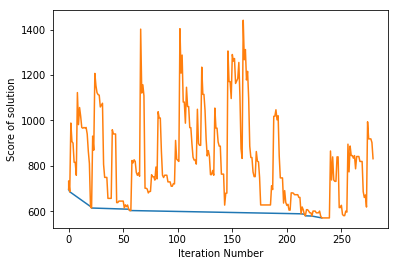

In [70]:
print('numIter:',numIter)
print('destroyN:',destroyN)
print('destroyB:',destroyB)
print('repairN',repairN)
print('repairB',repairB)
print('customerRepairN', customerRepairN)
print('customerDestroyN', customerDestroyN)
print('customerRepairB', customerRepairB)
print('customerDestroyB', customerDestroyB)

# scores.sort(reverse=True)
# plt.plot([x[0] for x in scores],[x[1] for x in scores])
plt.plot([x[0] for x in bestScores],[x[1] for x in bestScores])
plt.plot([x[0] for x in scores],[x[1] for x in scores])
plt.ylabel('Score of solution')
plt.xlabel('Iteration Number')
# sortedScore = sorted(scores,reverse=True)
# plt.plot(sortedScore)
# plt.ylabel('Score of solution')
# plt.xlabel('Iteration Number')

In [71]:
scheduler.getScheduleKPI()

(269.0431969119983, 214.63692124099998, 143.09128082733332, 290.398351351)

In [72]:
#{0: [3-TO-4-17-60-100-A,
#  1-TO-1-6-60-90-B,
#  0-TO-0-10-30-90-A,
#  6-TO-11-6-120-130-A,
#  9-TO-16-13-150-180-A],
# 1: [2-TO-2-7-60-75-C,
#  4-TO-5-13-80-95-B,
#  5-TO-8-3-100-125-C,
#  7-TO-12-7-130-140-B,
#  8-TO-1-10-140-160-C]}


scheduler.layout.getDistanceFromNode(18,0)+scheduler.layout.getDistanceFromNode(10,4)+ \
scheduler.layout.getDistanceFromNode(17,1)+scheduler.layout.getDistanceFromNode(6,11)+ \
scheduler.layout.getDistanceFromNode(6,16)
#scheduler.layout.getDistanceFromNode(19,2)+ \
#scheduler.layout.getDistanceFromNode(7,5)+scheduler.layout.getDistanceFromNode(13,12)+ \
#scheduler.layout.getDistanceFromNode(7,8)+scheduler.layout.getDistanceFromNode(3,1)
# +scheduler.layout.getDistanceFromNode(5,13)

51.421145165

In [73]:
(214.929/scheduler.agvs[1].speed) *scheduler.agvs[1].dischargeRate

71.643

In [74]:
44/scheduler.agvs[0].speed

29.333333333333332

In [75]:
# scheduler.customerALNSMethods.shawRemoval()

In [76]:
# scheduler.customerALNSMethods.repairInsertRandomTasks()
# scheduler.customerALNSMethods.repairInsertGreedyTasks()

In [77]:
# solved=True
# for i in range(100):
#     scheduler.customerALNSMethods.shawRemoval()
#     scheduler.customerALNSMethods.repairInsertGreedyTasks()
#     scheduler.createTaskSequence()
#     solved=scheduler.solveLP(printOutput=False)

In [78]:
scheduler.taskList

{0: [0-TO-0-10-30-90-A,
  3-TO-4-17-60-100-A,
  1-TO-1-6-60-90-B,
  7-TO-12-7-130-140-B,
  6-TO-11-6-120-130-A,
  10-TO-4-14-170-190-B,
  9-TO-16-13-150-180-A,
  12-TO-4-17-215-300-A,
  999-C-17-18,
  15-TO-11-6-400-425-A,
  16-TO-12-7-420-480-B,
  18-TO-16-13-470-490-A,
  19-TO-4-14-500-550-B],
 1: [2-TO-2-7-60-75-C,
  4-TO-5-13-80-95-B,
  5-TO-8-3-100-125-C,
  8-TO-1-10-140-160-C,
  11-TO-5-17-190-220-C,
  13-TO-5-13-280-300-B,
  14-TO-8-3-320-350-C,
  17-TO-1-10-440-460-C,
  999-C-10-19,
  20-TO-5-17-550-600-C]}